# Beyond Churn Prediction and Churn Uplift

Why predicting churn is not enough. And not even estimating churn uplift!

You need to estimate the impact on profits in order to get the best result

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *
from src.dgp import DGP

Suppose we 

In [3]:
class dgp_subscription_program(DGP):
    """DGP: promotional email"""
    X: list[str] = ['age', 'rev_old', 'rev_change']
    D: str = 'ad'
    Y: list[str] = ['churn', 'revenue']

    def generate_baseline(self, seed:int = 0):
        np.random.seed(seed)
        age = np.random.uniform(20, 50, self.n)
        rev_old = np.maximum(0, np.random.exponential(7, self.n) - 2)
        rev_change = np.random.normal(0, 2, self.n)
        churn_c = np.random.beta(1 - rev_change*(rev_change<0), 2 + rev_old) > 0.4
        rev_c = 0.8*rev_old + 0.2*np.maximum(0, np.random.exponential(7, self.n) - 2)
        df = pd.DataFrame({'age': age, 'rev_old': rev_old, 'rev_change': rev_change,
                           'churn_c': churn_c, 'revenue_c': rev_c})
        return df

    def add_treatment_effect(self, df, seed:int = 1):
        np.random.seed(seed)
        effect_c = - np.random.binomial(1, 0.3, self.n) * (df.age<40)
        df['effect_on_churn'] = effect_c * (df.churn_c==1)
        effect_r = np.random.normal(0.9, 0.5, self.n)* (df.age>30)
        df['effect_on_revenue'] = np.maximum(-df.revenue_c, effect_r)
        return df

    def add_assignment(self, df: pd.DataFrame, seed: int = 2) -> pd.DataFrame:
        np.random.seed(seed)
        df[self.D] = np.random.binomial(1, 0.5, self.n)
        return df

    def add_post_treatment_variables(self, df : pd.DataFrame, seed: int = 0) -> pd.DataFrame:
        df.revenue *= (1-df.churn)
        return df

In [4]:
dgp = dgp_subscription_program(n=100_000)
df = dgp.generate_data()
df.head()

,age,rev_old,rev_change,ad,churn,revenue
0,36.46,3.36,0.86,0,0,7.28
1,41.46,14.41,-2.77,1,0,11.60
2,38.08,2.89,-2.21,0,0,3.59
3,36.35,0.00,-3.26,0,1,0.00
4,32.71,3.25,-3.43,0,0,5.33


```mermaid
flowchart TD
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:3px;
classDef empty width:-1px,height:-1px,stroke:#000000,stroke-width:3px;

W((mail))
Y1((churn))
Y2((revenue))
X1((age))
X2((revenue change))
X3((revenue old))

W --- D1[ ]:::empty
X1 --- D1
D1 --> Y1
W --- D2[ ]:::empty
X1 --- D2
D2 --> Y2
Y1 --> Y2
X2 --> Y1
X3 --> Y1
X3 --> Y2

class W,Y1,Y2,X1,X2,X3 included;

linkStyle 0,2,3,5 stroke:#2db88b,stroke-width:6px;
linkStyle 1,4,6,7,8,9 stroke:#003f5c,stroke-width:6px;
```

```mermaid
graph TD

W((mail))
Y1((churn))
Y2((revenue))
X1((age))
X2((revenue change))
X3((revenue old))

W --- D1[ ]:::empty
X1 --- D1
D1 --> Y1
W --- D2[ ]:::empty
X1 --- D2
D2 --> Y2
Y1 --> Y2
X2 --> Y1
X3 --> Y1
X3 --> Y2

classDef empty width:0px,height:0px;
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:3px;

linkStyle 0,2,3,5 stroke:#2db88b,stroke-width:6px;
linkStyle 1,4,6,7,8,9 stroke:#003f5c,stroke-width:6px;

class W,Y1,Y2,X1,X2,X3 included;
```

In [5]:
df.churn.mean()

0.20442

In [6]:
Y = ['churn', 'revenue']
W = 'ad'
X = ['age', 'rev_old', 'rev_change']

In [7]:
smf.ols("churn ~ ad + " + " + ".join(X), data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2439,0.005,48.777,0.000,0.234,0.254
ad,-0.1036,0.002,-45.017,0.000,-0.108,-0.099
age,0.0032,0.000,23.933,0.000,0.003,0.003
rev_old,-0.0187,0.000,-110.552,0.000,-0.019,-0.018
rev_change,-0.0514,0.001,-89.230,0.000,-0.052,-0.050


<Axes: xlabel='revenue', ylabel='Count'>

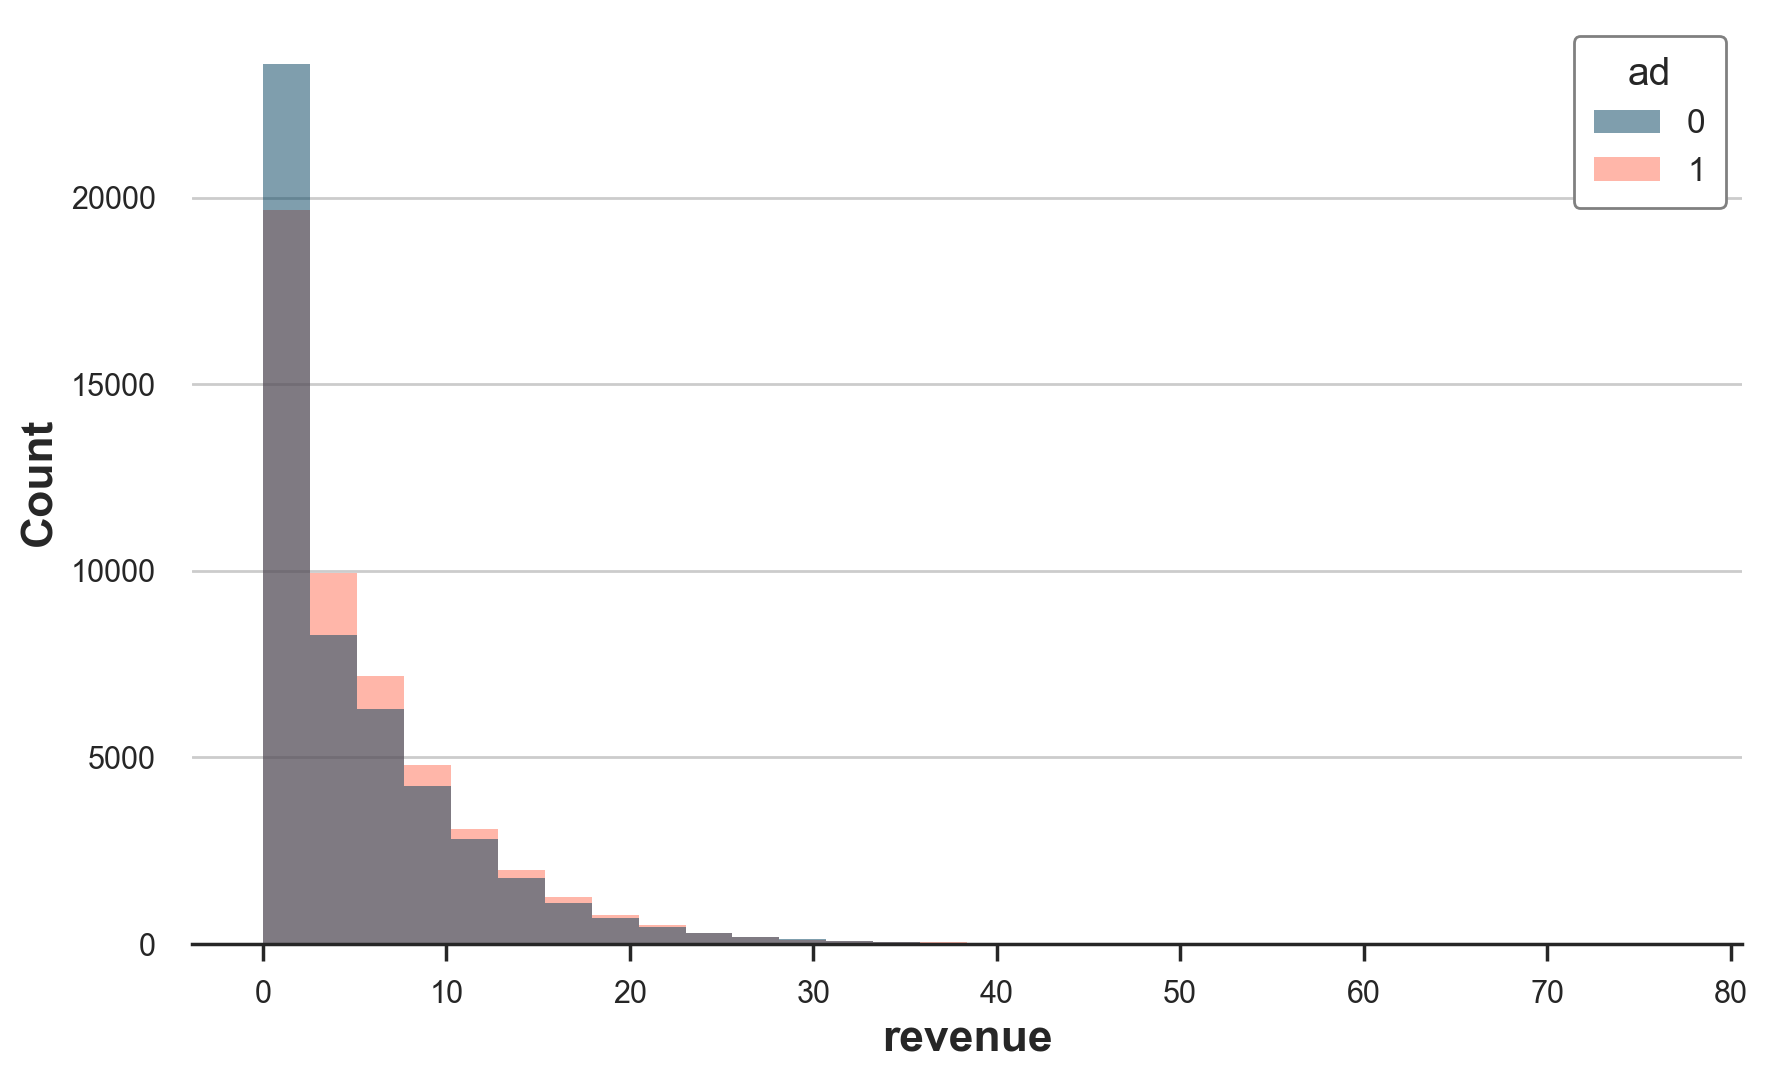

In [8]:
sns.histplot(data=df, x='revenue', hue='ad', bins=30)

In [9]:
smf.ols("revenue ~ ad + " + " + ".join(X), data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1226,0.023,5.444,0.000,0.078,0.167
ad,0.6921,0.010,66.754,0.000,0.672,0.712
age,0.0085,0.001,14.243,0.000,0.007,0.010
rev_old,0.8267,0.001,1083.735,0.000,0.825,0.828
rev_change,0.1516,0.003,58.501,0.000,0.147,0.157


True effects

In [10]:
def plot_avg_by_age(df, var, ax, **kwargs):
    temp = df.copy()
    temp['age'] = temp['age'].round(0)
    temp = temp.groupby('age', as_index=False)[[var]].mean()
    sns.lineplot(data=temp, x='age', y=var, ax=ax).set(ylabel='', **kwargs)

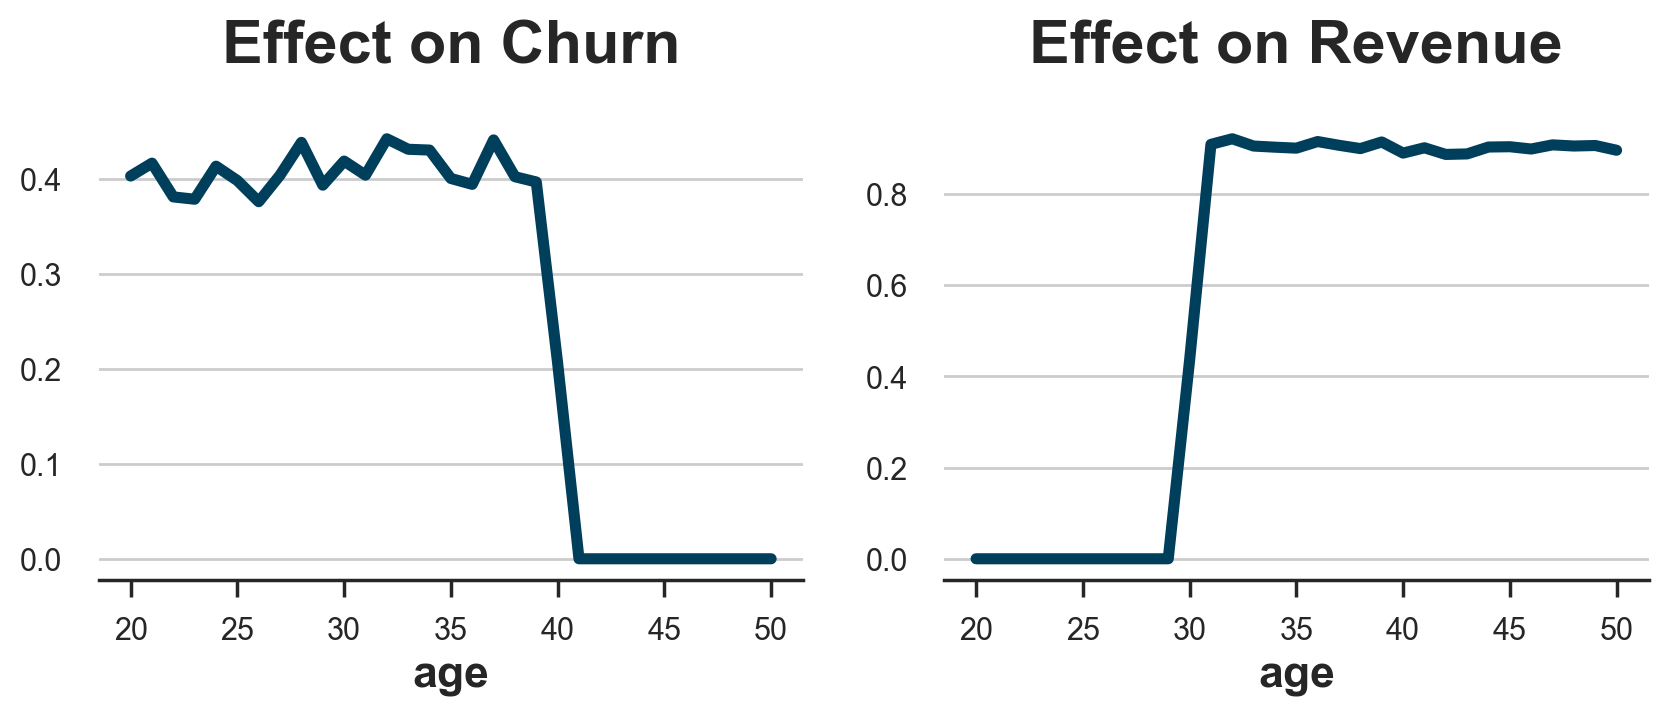

In [11]:
df_true = dgp.generate_data(keep_po=True)
df_true['churn_effect'] = np.mean(df_true['revenue_c']) * -df_true['effect_on_churn']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
plot_avg_by_age(df_true, 'churn_effect', ax1, title="Effect on Churn")
plot_avg_by_age(df_true, 'effect_on_revenue', ax2, title="Effect on Revenue")

In [12]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from flaml.default import LGBMClassifier, LGBMRegressor, RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

model_y = LGBMRegressor()
model_w = LGBMClassifier()

In [13]:
from econml.dr import DRLearner

In [14]:
cost = 1

In [15]:
def evaluate_policy(policy):
    data = dgp.generate_data(seed_data=11, seed_assignment=12, keep_po=True)
    data['profits'] = (1 - data.churn) * data.revenue
    ad = policy(data)
    baseline = (1-data.churn_c) * data.revenue_c
    effect = (ad) * (1-data.churn_t) * (data.revenue_t-cost) + (1-ad) * (1-data.churn_c) * data.revenue_c
    return np.sum(effect - baseline)

In [16]:
optimal_policy_churn = lambda df : - df['effect_on_churn'] * df['revenue_c'] > cost
evaluate_policy(optimal_policy_churn)

7419.17

In [17]:
optimal_policy_revenue = lambda df : df['effect_on_revenue'] * (1 - df['churn_c']) > cost
evaluate_policy(optimal_policy_revenue)

7644.88

In [18]:
optimal_policy_interaction = lambda df : - df['effect_on_churn'] * df['effect_on_revenue'] > cost
evaluate_policy(optimal_policy_interaction)

2338.5699999999997

In [19]:
def optimal_policy(df):
    pi = - df['effect_on_churn'] * (df['revenue_c'] + df['effect_on_revenue'])  
    pi += df['effect_on_revenue'] * (1 - df['churn_c'])
    return pi > cost
evaluate_policy(optimal_policy)

15443.74

Target churning customers

In [20]:
model_churn = clone(model_w).fit(X=df[X], y=df['churn'])

policy_churn = lambda df : (model_churn.predict_proba(df[X])[:,1] > 0.2)
evaluate_policy(policy_churn)

-3651.9999999999995

Target revenue customers

In [21]:
model_revenue = clone(model_y).fit(X=df[X], y=df['revenue'])

policy_revenue = lambda df : (model_revenue.predict(df[X]) > 10*cost)
evaluate_policy(policy_revenue)

-5835.28

Target churn uplift customers

In [22]:
DR_learner_churn = DRLearner(model_regression=model_y, model_propensity=model_w, model_final=model_y)
DR_learner_churn.fit(df['churn'], df[W], X=df[X]);

policy_churn_lift = lambda df : DR_learner_churn.effect(df[X]) < 0
evaluate_policy(policy_churn_lift)

-20967.050000000003

In [23]:
DR_learner_churn = DRLearner(model_regression=model_y, model_propensity=model_w, model_final=model_y)
DR_learner_churn.fit(df['churn'], df[W], X=df[X]);
model_revenue_1 = clone(model_y).fit(X=df.loc[df.ad == 1, X], y=df.loc[df.ad == 1, 'revenue'])

policy_churn_lift = lambda df : - DR_learner_churn.effect(df[X]) * model_revenue_1.predict(df[X]) > cost
evaluate_policy(policy_churn_lift)

615.96

Combine 

$$
\tau_{\pi} = \hat{r}_1 * (1 - \hat{c}_1) - \hat{r}_0 * (1 - \hat{c}_0)
$$

which we can rewrite as 

$$
\begin{aligned}
\tau_{\pi} &= \hat{r}_1 * (1 - \hat{c}_1) - \hat{r}_0 * (1 - \hat{c}_0) = \newline
&= \hat{r}_1 * (1 - \hat{c}_1) - \underbrace{\hat{r}_1 * (1 - \hat{c}_0) + \hat{r}_1 * (1 - \hat{c}_0)}_{\text{add and subtract}} - \hat{r}_0 * (1 - \hat{c}_0) = \newline
&= - \hat{r}_1 * \tau_c + \hat{r}_1 * (1 - \hat{c}_0) - \hat{r}_0 * (1 - \hat{c}_0) = \newline
&= - \hat{r}_1 * \tau_c + \tau_r * (1 - \hat{c}_0)
\end{aligned}
$$

In [24]:
model_churn_0 = clone(model_w).fit(X=df.loc[df.ad == 0, X], y=df.loc[df.ad == 0, 'churn'])

df_surv = df[df.churn == 0]
DR_learner_survrev = DRLearner(model_regression=model_y, model_propensity=model_w, model_final=model_y)
DR_learner_survrev.fit(df_surv['revenue'], df_surv[W], X=df_surv[X]);

def policy_comb_lift(df): 
    pi = - DR_learner_churn.effect(df[X]) * model_revenue_1.predict(df[X])
    pi += DR_learner_survrev.effect(df[X]) * (1 - model_churn_0.predict(df[X]))
    return pi > cost
evaluate_policy(policy_comb_lift)

1006.41

Target revenue uplift customers

In [25]:
DR_learner_revenue = DRLearner(model_regression=model_y, model_propensity=model_w, model_final=model_y)
DR_learner_revenue.fit(df['revenue'], df[W], X=df[X]);

policy_revenue_lift = lambda df : (DR_learner_revenue.effect(df[X]) > cost)
evaluate_policy(policy_revenue_lift)

2334.9300000000003

Plot

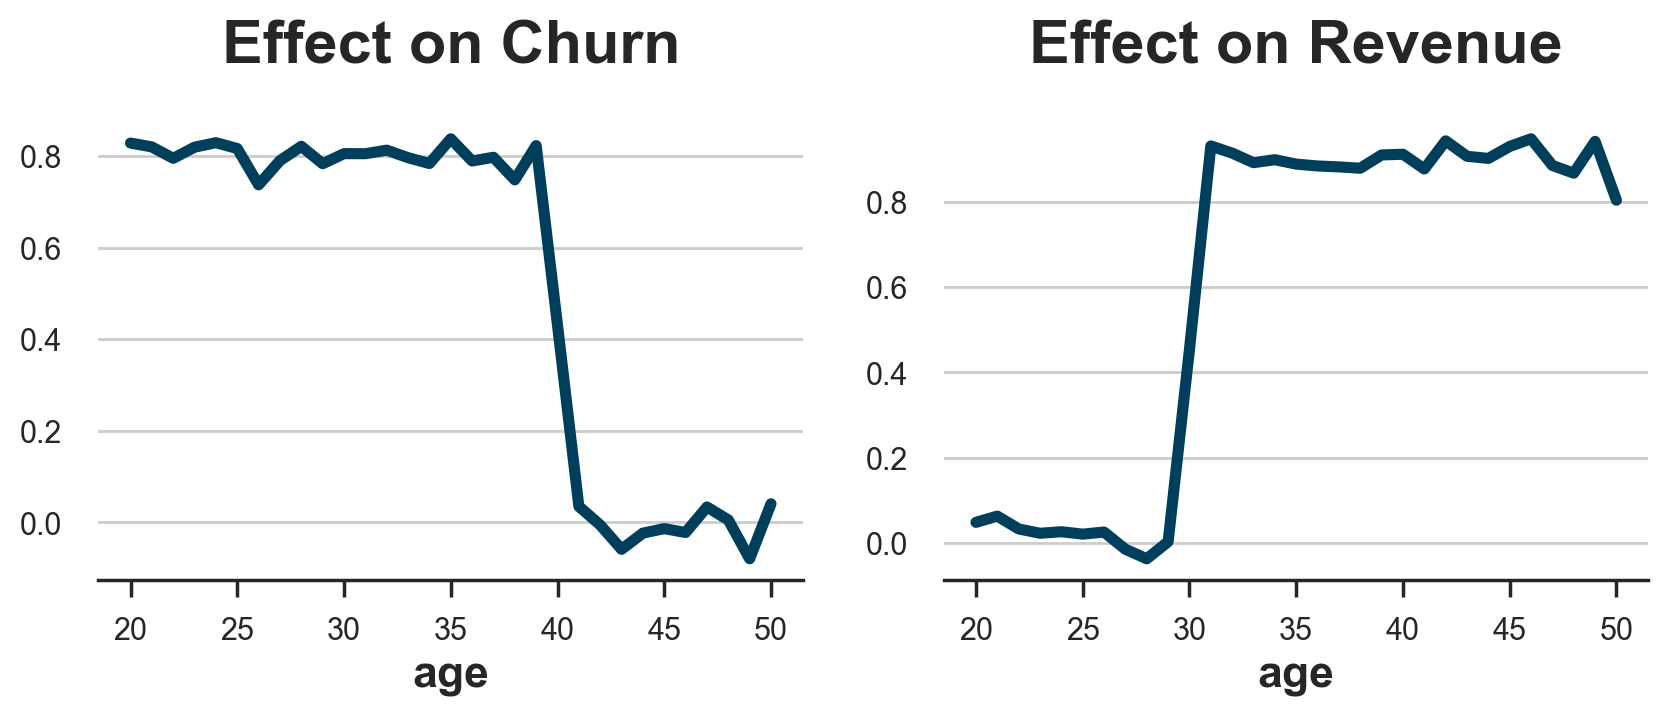

In [27]:
df['effect_churn_hat'] = np.mean(model_revenue.predict(df[X])) * -DR_learner_churn.effect(df[X])
df['effect_revenue_hat'] = DR_learner_survrev.effect(df[X])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
plot_avg_by_age(df, 'effect_churn_hat', ax1, title="Effect on Churn")
plot_avg_by_age(df, 'effect_revenue_hat', ax2, title="Effect on Revenue")

In [28]:
policies = [policy_churn, policy_revenue, policy_churn_lift, policy_comb_lift, policy_revenue_lift, policy_revenue_lift_w] 
df_results = pd.DataFrame()
df_results['policy'] = ['churn', 'revenue', 'churn_L', 'comb_L', 'revenue_L', 'revenue_Lw']
df_results['value'] = [evaluate_policy(policy) for policy in policies]

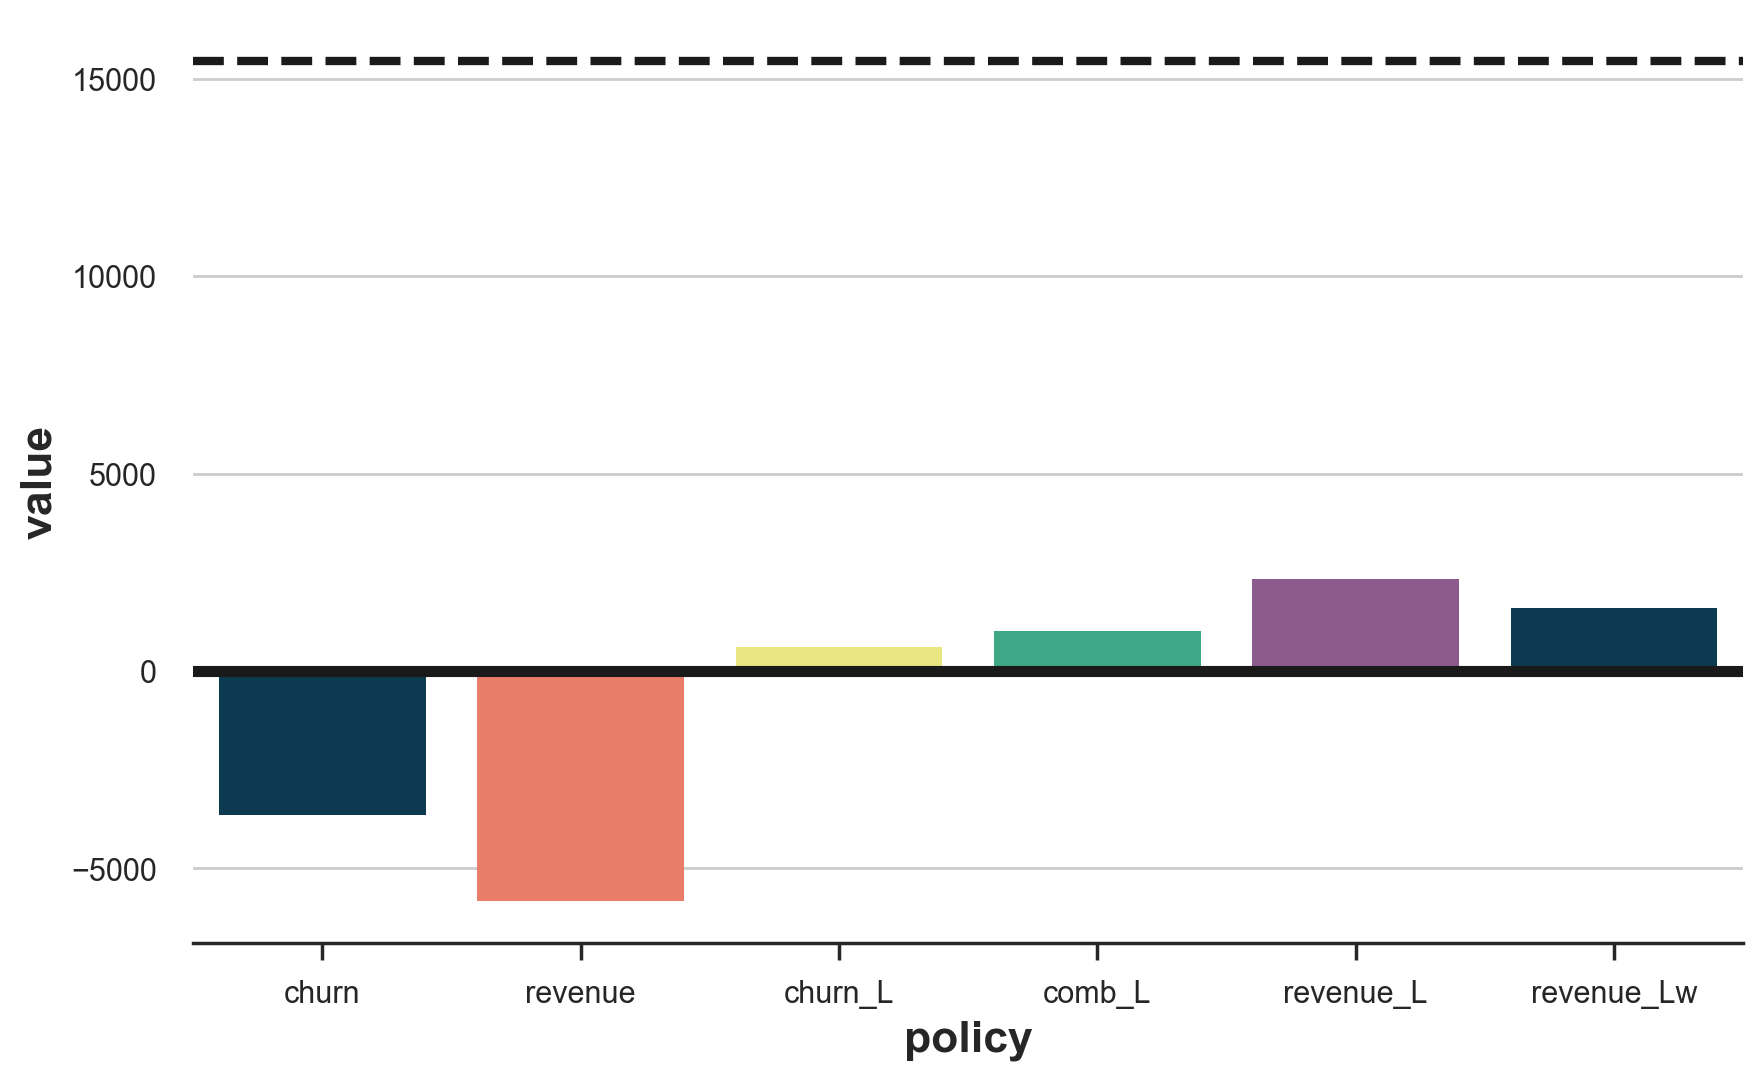

In [29]:
fig, ax = plt.subplots()
sns.barplot(df_results, x='policy', y='value')
plt.axhline(0, c='k')
plt.axhline(evaluate_policy(optimal_policy), c='k', ls='--', lw=3)

### Bonus: weighting

In [30]:
DR_learner_revenue_w = DRLearner(model_regression=model_y, model_propensity=model_w, model_final=model_y)
w = np.exp(1 - np.abs(DR_learner_revenue.effect(df[X]) - cost))
DR_learner_revenue_w.fit(df['revenue'], df[W], X=df[X], sample_weight=w);

policy_revenue_lift_w = lambda df : (DR_learner_revenue_w.effect(df[X]) > cost)
evaluate_policy(policy_revenue_lift_w)

1597.41

## Conclusion

### References

- Lemmens, Gupta (2020), ["Managing Churn to Maximize Profits"](https://www.hbs.edu/ris/Publication%20Files/14-020_2d6c9da0-94d3-4dd5-9952-d81feb432f61.pdf)

- Bonvini, Kennedy, Keele (2021), ["Minimax optimal subgroup identification"](https://arxiv.org/abs/2306.17464)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/beyond_churn.ipynb